In [10]:
import glob
from IPython.display import display, HTML
%matplotlib inline
from image_features import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

/home/admin1/anaconda3/envs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## hyper-parameters

In [2]:
# Parameters for tuning model learning. 
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 4  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

## read data

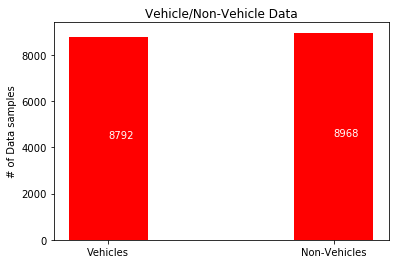

In [3]:
# import data from vehicles and not-vehicles data directories
images = glob.glob('data/*/*/*.png')

vehicles = []
nonvehicles = []
for image in images:
    if 'non-vehicles' in image:
        nonvehicles.append(image)
    else:
        vehicles.append(image)

data = (len(vehicles),len(nonvehicles))
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, data, width, color='r')
ax.set_ylabel('# of Data samples')
ax.set_title('Vehicle/Non-Vehicle Data')
ax.set_xticks(ind)
ax.set_xticklabels(('Vehicles', 'Non-Vehicles'))
for i, v in enumerate(data):
    ax.text(i, v /2, str(v), color='white')


## data visualization

In [4]:
def get_random_image(image_paths):
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_data(data, title):
    plt.figure(figsize=(10, 4))
    img_num = 1
    show_samples_count = 5

    for i in range(show_samples_count):
        plt.subplot(1, show_samples_count, img_num)   
        img_num += 1
        img = get_random_image(data)
        plt.imshow(img)
        plt.title("{}".format(title), fontsize=10)
        plt.axis('off')

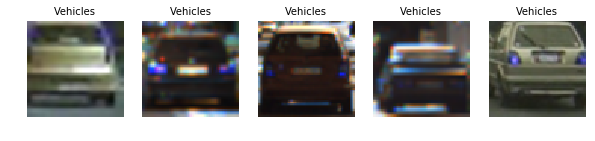

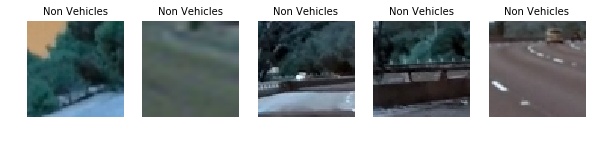

In [5]:
display_data(vehicles, "Vehicles")
display_data(nonvehicles, "Non Vehicles")

## Hog Features

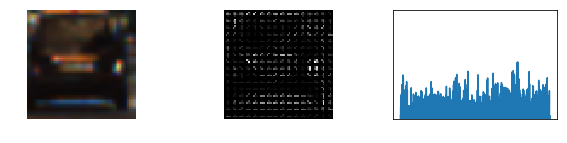

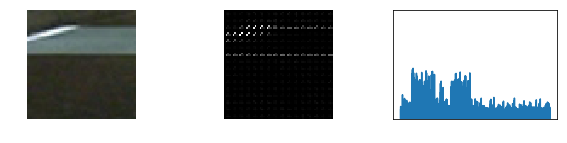

In [6]:
def plot_hog_sample(image, hog_image, hog_features):
    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot regular image
image = get_random_image(vehicles)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot hog image
image = get_random_image(nonvehicles)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

## Color Histogram

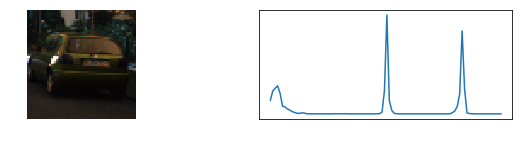

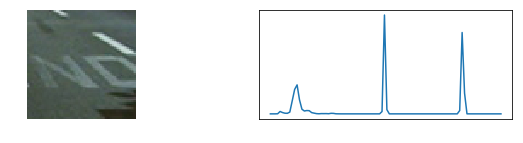

In [7]:
def plot_color_histogram_sample(image, yuv_image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(color_hist(yuv_image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive image
image = get_random_image(vehicles)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

# plot negative image
image = get_random_image(nonvehicles)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

## Binned Color

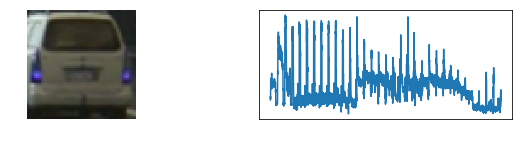

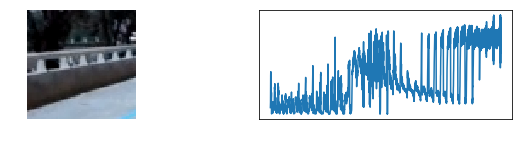

In [8]:
def plot_bin_spatial_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(vehicles)
plot_bin_spatial_sample(image)

# plot negative image
image = get_random_image(nonvehicles)
plot_bin_spatial_sample(image)

## Extract Image features and Scaler

In [9]:
vehicle_features = extract_features_files(vehicles, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
nonvehicle_features = extract_features_files(nonvehicles, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

print('Feature Scaling for Vehicles (', len(vehicle_features),') and Non-Vehicles (', len(nonvehicle_features), ') Completed')

Feature Scaling for Vehicles ( 8792 ) and Non-Vehicles ( 8968 ) Completed


In [11]:
n_pca_comp = 25
pca = PCA(n_components=n_pca_comp, whiten=True)
pca = pca.fit(scaled_X)
pca_features = pca.transform(scaled_X)

MemoryError: 